# Generate samples from three types of point processes:
1. Homogeneous Poisson process
2. Non-homogeneous Neyman-Scott process
3. Non-homogeneous Log-Gaussian Cox process

In [9]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import CubicSpline

# Homogeneous Poisson Process
def get_poisson_process_samples(rate):
    """
    Generate sample data where the number of samples are Poisson distributed 
    and the values are uniformly distributed on [0,1].
    """
    s = np.random.poisson(rate)
    return np.random.rand(s)

# Inhomogeneous Poisson Processes (next two functions)
def get_neyman_scott_process(lambda_p, lambda_c, sigma):
    """
    Simulate a Neyman-Scott process in 1D.
    
    Parameters:
    - lambda_p: Intensity of parent points (mean number of parents per unit length)
    - lambda_c: Mean number of offspring per parent
    - sigma: Standard deviation of the normal distribution for offspring displacement
    
    Returns:
    - Array of points sampled from the Neyman-Scott process
    """
    # 1. Generate parent points
    num_parents = np.random.poisson(lambda_p)
    parent_points = np.random.uniform(0, 1, num_parents)
    
    offspring_points = []
    
    # 2. For each parent, generate offspring
    for parent in parent_points:
        num_offspring = np.random.poisson(lambda_c)
        displacements = np.random.normal(0, sigma, num_offspring)
        offspring = parent + displacements
        offspring_points.append(offspring)
    
    # Combine all points into a single array
    return np.concatenate((np.concatenate(offspring_points), parent_points))

def get_log_gaussian_cox_process(dx, mean_log_intensity, variance, length_scale):
    # Discretize space
    x = np.arange(0, 1, dx)
    n = len(x)
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(x[:, None], x[:, None], metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian Process)
    mean_vector = mean_log_intensity * np.ones(n)
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get positive intensities
    Lambda = np.exp(G)
    
    # Create a continuous intensity function using interpolation
    Lambda_hat = CubicSpline(x, Lambda)
    
    plt.plot(x, Lambda, marker='.',linestyle=None, label='Intensity Function $\\Lambda(x)$')
    plt.plot(x, Lambda_hat(x), label='Interpolated Intensity Function $\\hat{\\Lambda}(x)$', linestyle='--')
    
    # Simulate Poisson points using the thinning algorithm
    lambda_max = np.max(Lambda)
    points = get_poisson_process_samples(lambda_max)
    lambda_points = Lambda_hat(points)
    probability_threshold = np.clip(lambda_points / lambda_max, 0,1)
    probabilities = np.random.rand(len(points))
    return points[probabilities <= probability_threshold]

def get_log_gaussian_cox_process_direct_sampling(dx, mean_log_intensity, variance, length_scale):
    # Discretize space
    x = np.arange(0, 1, dx)
    n = len(x)
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(x[:, None], x[:, None], metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian Process)
    mean_vector = mean_log_intensity * np.ones(n)
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get positive intensities
    Lambda = np.exp(G)
    
    # Now simulate Poisson points
    points = []
    for xi, lam in zip(x, Lambda):
        expected_points = lam * dx
        num_points = np.random.poisson(expected_points)
        points.extend(xi + dx * np.random.rand(num_points))
    
    return np.array(points)
    

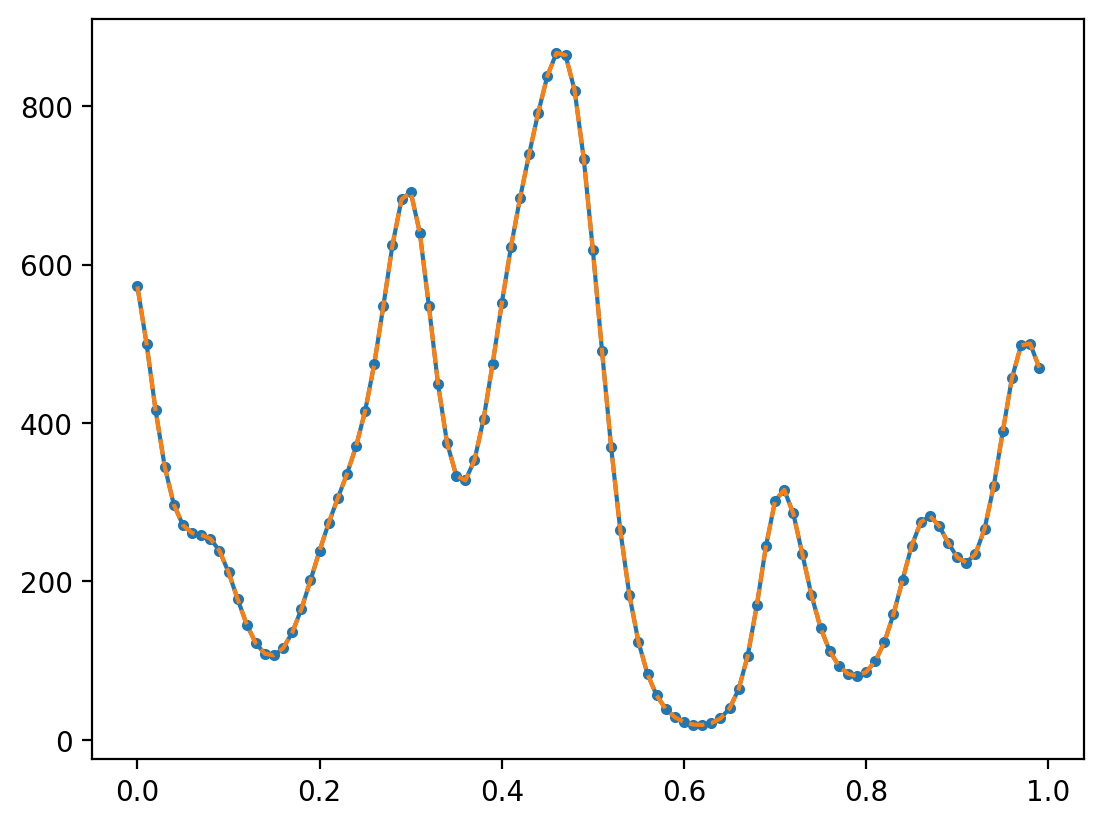

In [12]:
# Parameters
L = 1             # Length of domain
dx = 0.01          # Bin width
mean_log_intensity = np.log(200)  # Mean of log-intensity
variance = 1     # Variance of the Gaussian Process
length_scale = 0.05 # Length scale of covariance

_ = get_log_gaussian_cox_process(dx, mean_log_intensity, variance, length_scale)

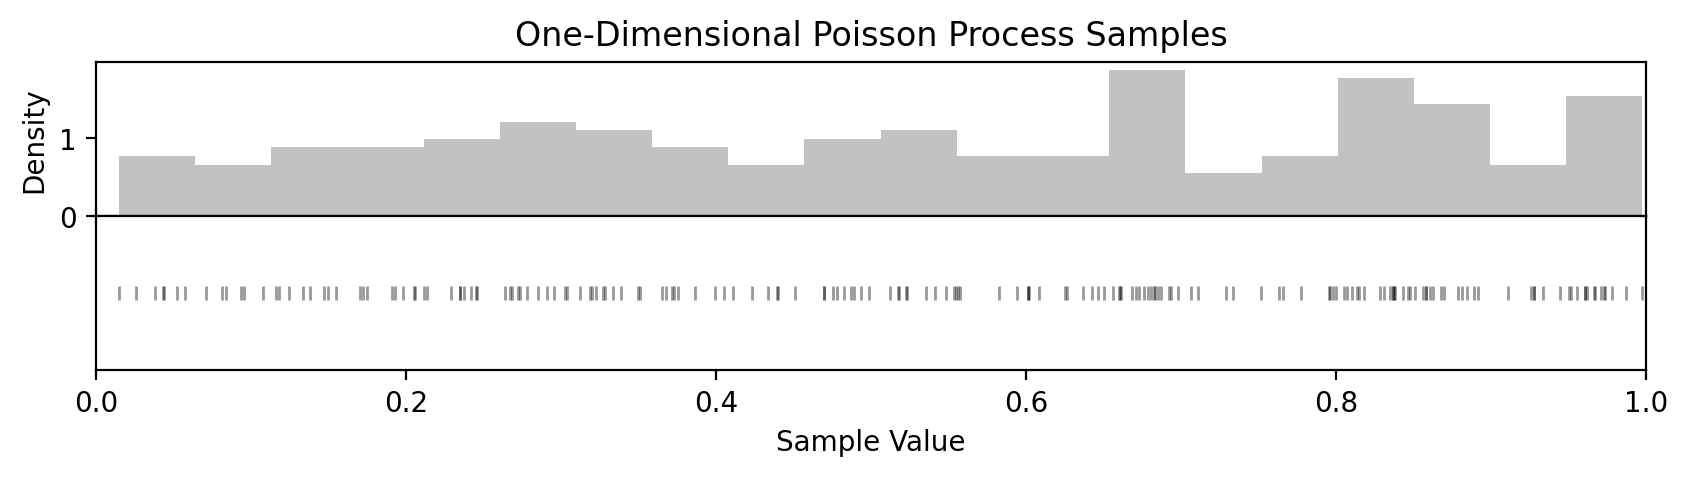

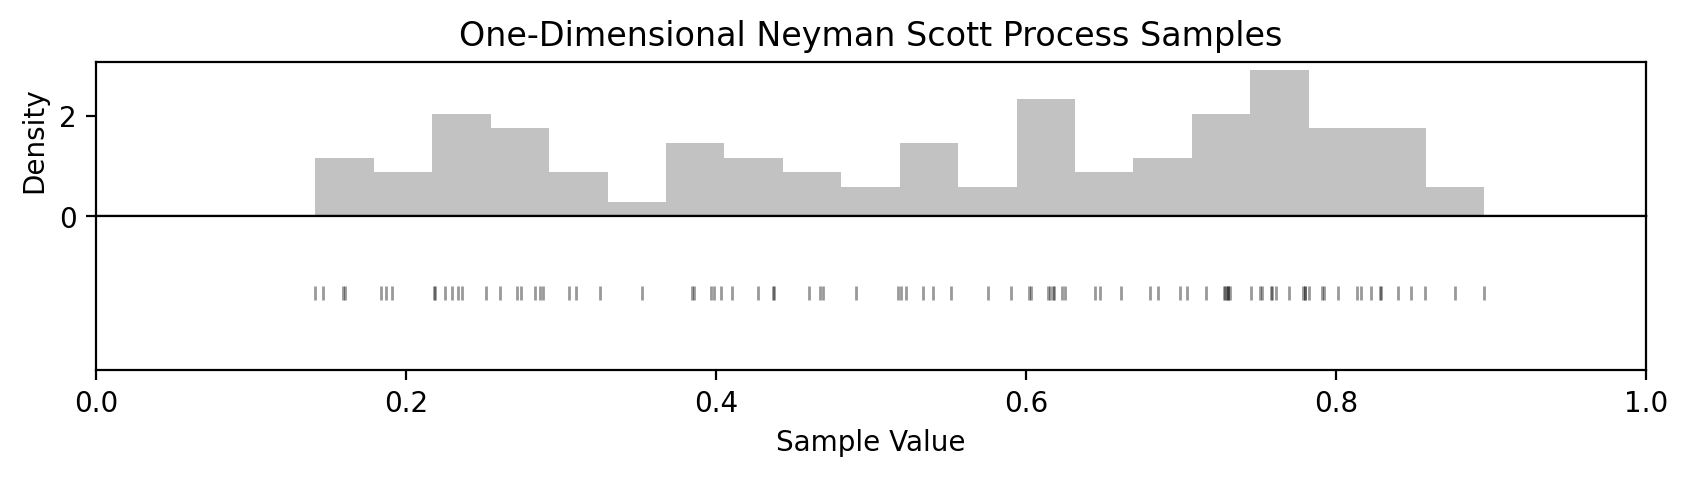

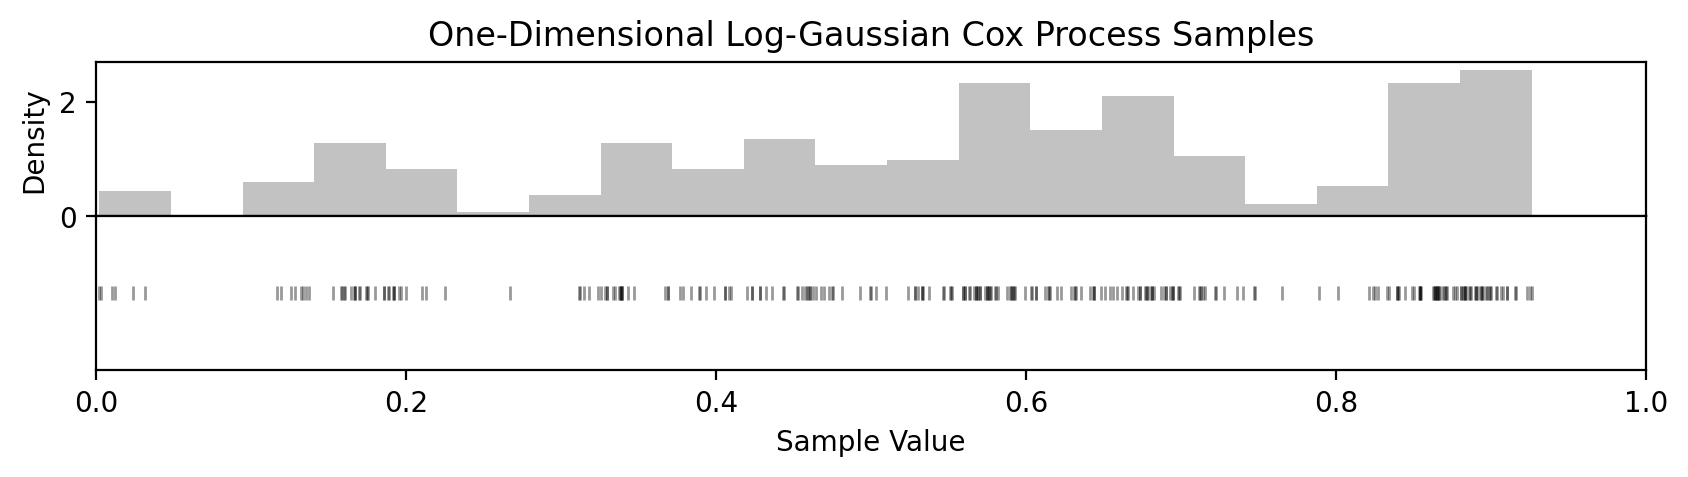

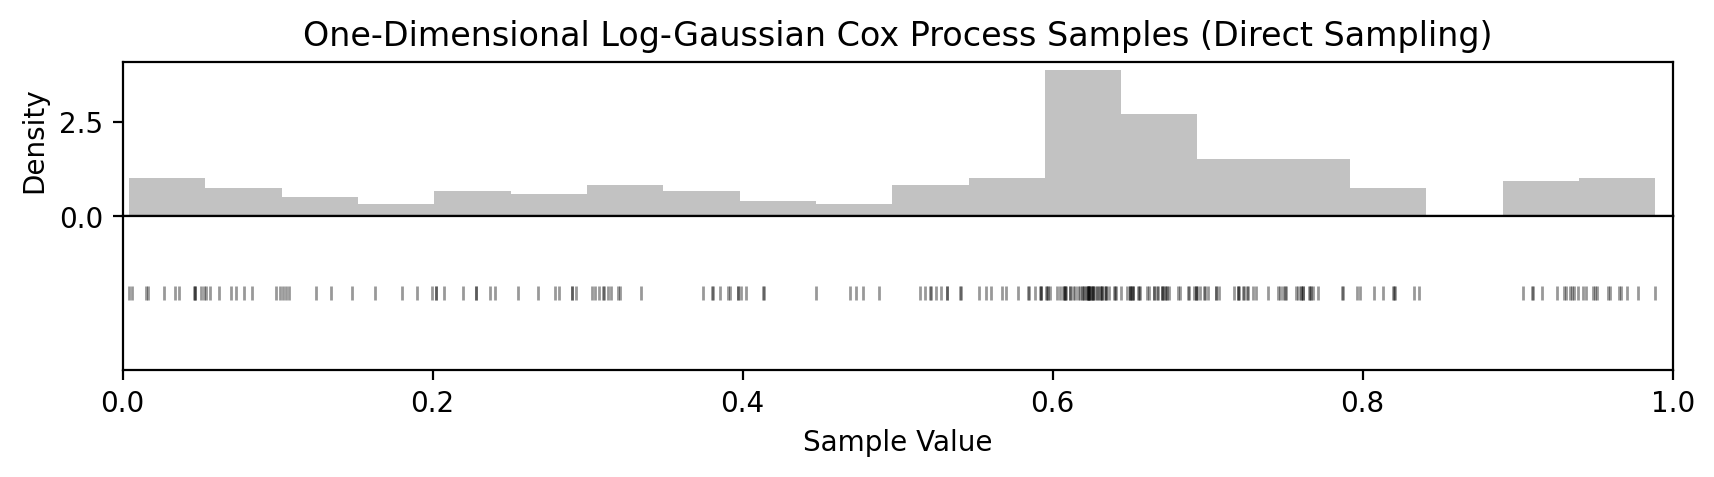

In [6]:

def plot_one_d_samples(samples, title):
    """
    Plot one-dimensional samples.
    """
    fig, ax = plt.subplots(2,1,figsize=(10, 2), gridspec_kw={'height_ratios': [1, 1]})
    
    # Add a histogram to visualize the distribution of samples
    ax[0].hist(samples, bins=20, density=True, alpha=0.7, color='darkgrey')
    ax[0].set(
        title=title,
        xlabel='Sample Value',
        ylabel='Density',
        xlim=(0, 1),
        xticks=[],
    )
    
    # Plot the samples as vertical lines
    ax[1].plot(samples, np.zeros_like(samples), 
               marker='|',
               color='black',
               markersize=5,
               linestyle='None',
               alpha=0.4)
    ax[1].set(
        yticks=[],
        xlim=(0, 1),
        xlabel='Sample Value'
    )
    
    plt.subplots_adjust(hspace=0)

# Parameters for Poisson Process
N = 200

# Parameters for Neyman-Scott Process
lambda_p = 10
lambda_c = N / lambda_p
sigma = 0.05

# Parameters for log-Gaussian Cox Process
L = 1             # Length of domain
dx = 0.001          # Bin width
mean_log_intensity = np.log(N)  # Mean of log-intensity
variance = 1     # Variance of the Gaussian Process
length_scale = 0.05 # Length scale of covariance

data = {}
data['poisson'] = get_poisson_process_samples(N)
data['neyman-scott'] = get_neyman_scott_process(lambda_p, lambda_c, sigma)
data['lgcp'] = get_log_gaussian_cox_process(dx, mean_log_intensity, variance, length_scale)
data['lgcp_direct'] = get_log_gaussian_cox_process_direct_sampling(dx, mean_log_intensity, variance, length_scale)

# Plot the one-dimensional Poisson process samples
plot_one_d_samples(data['poisson'], 'One-Dimensional Poisson Process Samples')
plot_one_d_samples(data['neyman-scott'], 'One-Dimensional Neyman Scott Process Samples')
plot_one_d_samples(data['lgcp'], 'One-Dimensional Log-Gaussian Cox Process Samples')
plot_one_d_samples(data['lgcp_direct'], 'One-Dimensional Log-Gaussian Cox Process Samples (Direct Sampling)')
